# Deep Learning With MNIST Data
ummuglsmarsln@gmail.com 

If you don't have keras installed in your system, then use the following command to install it:

In [ ]:
!conda install -y keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import datetime
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

In [2]:
plt.rcParams["font.size"] = 30
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.titlesize'] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 10

In [3]:
BASE_DIR = "."
DEBUG = False

np.random.seed(42)

Let's run a shell command from within this notebook to check the version of Keras package we have in system:

In [10]:
!pip show keras

Name: keras
Version: 2.9.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\ummug\anaconda3\lib\site-packages
Requires: 
Required-by: tensorflow


The MNIST data is already available in keras and can be loaded using:

In [10]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [11]:
# Here we count the number of (how many from each of the classes) unique train labels. 

unique, counts = np.unique(Y_train, return_counts=True)
print("For train dataset - labels: \n", dict(zip(unique, counts)))

For train dataset - labels: 
 {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [12]:
# Here we count the number of (how many from each of the classes) unique test labels. 

unique, counts = np.unique(Y_test, return_counts=True)
print("For test dataset - labels: \n", dict(zip(unique, counts)))

For test dataset - labels: 
 {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Now, we can visualize some digits:

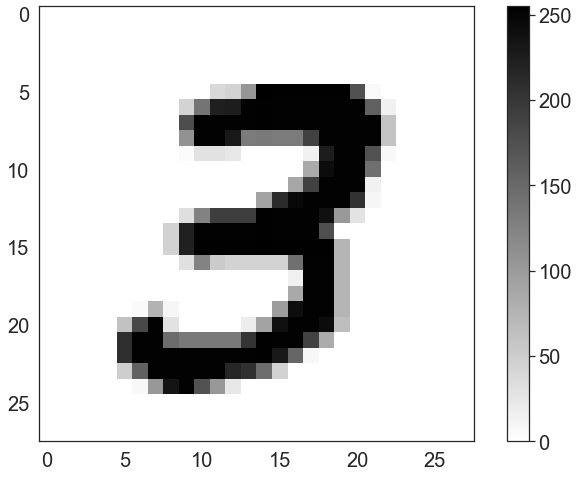

In [13]:
img_array = X_train[7]
x = plt.imshow(img_array, interpolation = "antialiased", alpha = 1, cmap = plt.cm.binary)
plt.colorbar(x)
plt.show()

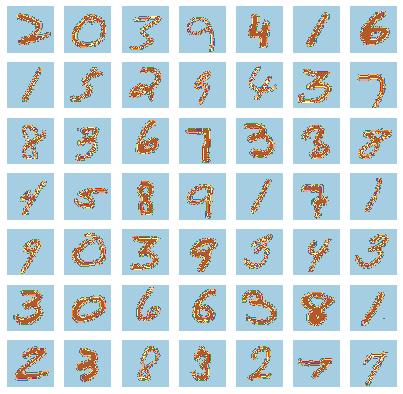

In [14]:
#Here we visualize 49 digits from train dataset

idxs = np.random.randint(0, X_train.shape[0], size = 49)
images = X_train[idxs]
labels = Y_train[idxs]
# pick the best
#cmap = plt.cm.get_cmap('YlOrRd')    # Sequential
#cmap = plt.cm.get_cmap('Paired')    # Categorical
#cmap = plt.cm.get_cmap('rainbow')   # Divergent, yellow in middle, has both green and red  
#cmap = plt.cm.get_cmap('Pastel2')   # Divergent
#cmap = plt.cm.get_cmap('jet')        # Divergent

#colors = 10*['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'gold', 'maroon', 'orange', 'purple']

plt.figure(figsize = (7, 7))
for i in range(len(idxs)):
    plt.subplot(7, 7, i + 1)
    image = images[i]
    plt.imshow(image, cmap='Paired')
    plt.axis('off')
    
plt.show()

Here we convert the values of our dataset to "float32" data type. Then we standardize them dividing by 255.Since 255 is the maximum value, dividing by 255 expresses a 0-1 representation. Each channel (Red, Green, and Blue are each channels) is 8 bits, so they are each limited to 256, in this case 255 since 0 is included. As the reference shows, systems typically use values between 0-1 when using floating point values.

In [27]:
X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype("float32") / 255

# One-Hot Encoding

We use One-hot encoding to ensure that machine learning does not assume that higher numbers are more important. For example, the value '6' is bigger than the value '2', but that does not make '6' more important than '2'.

In [28]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [48]:
# we look at encoded train labels
print("Encoded train labels\n", Y_train[0:5])
print("\nEncoded test labels\n", Y_test[0:5])

Encoded train labels
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

Encoded test labels
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Let's first build a Sequential Deep Learning Model


from datetime import datetime
start = datetime.now()
print("Time : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

In [55]:
from tensorflow.keras import layers
from tensorflow.python.keras import regularizers
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (28, 28, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation = "relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = "relu"))

model.add(layers.Flatten())

model.add(layers.Dense(128, kernel_regularizer = regularizers.l2(0.00001),
                       activation = "relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(10, kernel_regularizer = regularizers.l2(0.00001),
                       activation = "softmax"))

In [56]:
#COMPILING
epoch = 10
batch_size = 64

model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
model.fit(X_train, Y_train, epochs = epoch, batch_size = batch_size)

Epoch 1/10
938/938 [==============================] - 29s 30ms/step - loss: 0.1157 - accuracy: 0.9663
Epoch 2/10
938/938 [==============================] - 28s 30ms/step - loss: 0.0454 - accuracy: 0.9873
Epoch 3/10
938/938 [==============================] - 28s 30ms/step - loss: 0.0323 - accuracy: 0.9913
Epoch 4/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0271 - accuracy: 0.9922
Epoch 5/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0231 - accuracy: 0.9937
Epoch 6/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0202 - accuracy: 0.9948
Epoch 7/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0188 - accuracy: 0.9950
Epoch 8/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0157 - accuracy: 0.9964
Epoch 9/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0166 - accuracy: 0.9959
Epoch 10/10
938/938 [==============================] - 30s 32ms/step - loss: 0.014

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 11, 11, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
#MODEL PERFORMANCE
history = model.fit(X_train, Y_train, epochs = epoch, batch_size = batch_size,
                    shuffle = True, validation_split = 0.25)

Epoch 1/10
704/704 [==============================] - 25s 36ms/step - loss: 0.0118 - accuracy: 0.9975 - val_loss: 0.0130 - val_accuracy: 0.9971
Epoch 2/10
704/704 [==============================] - 23s 33ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.0181 - val_accuracy: 0.9959
Epoch 3/10
704/704 [==============================] - 23s 33ms/step - loss: 0.0105 - accuracy: 0.9982 - val_loss: 0.0186 - val_accuracy: 0.9955
Epoch 4/10
704/704 [==============================] - 24s 34ms/step - loss: 0.0102 - accuracy: 0.9982 - val_loss: 0.0225 - val_accuracy: 0.9942
Epoch 5/10
704/704 [==============================] - 24s 34ms/step - loss: 0.0140 - accuracy: 0.9968 - val_loss: 0.0208 - val_accuracy: 0.9943
Epoch 6/10
704/704 [==============================] - 25s 35ms/step - loss: 0.0091 - accuracy: 0.9987 - val_loss: 0.0230 - val_accuracy: 0.9949
Epoch 7/10
704/704 [==============================] - 25s 36ms/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 0.0175 - val_accuracy: